# T2D benchmark

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('../../')

In [2]:
import takco
conf = takco.Config('resources/config-dbpedia.toml')
t2dv2 = list(takco.TableSet.dataset(
    't2d-v2', 
    resourcedir=conf.get('resourcedir'), 
    assets=conf.get('assets')
))

takco.preview(t2dv2)

In [3]:
import takco.link

searcher_config = takco.Config({
    'name': 'es',
    'class': 'ElasticSearcher',
    'index': 'dbpediasub-6',
    'baseuri': 'http://dbpedia.org/resource/',
    'es_kwargs': {'hosts': ['bricks07']},
    'prop_uri': {'type': "http://www.w3.org/1999/02/22-rdf-syntax-ns#type"},
    'prop_baseuri': {'type': 'http://dbpedia.org/ontology/'},
})

# Test
with searcher_config.init_class(**takco.link.__dict__) as es:
    for r in es.search_entities('USA'):
        print(r.uri)

http://dbpedia.org/resource/United_States


In [4]:
from dask.distributed import Client
Client(address = 'tcp://192.168.62.207:8786')

<Client: 'tcp://192.168.62.207:8786' processes=8 threads=96, memory=538.48 GB>

In [5]:
%%time


pred = takco.TableSet.link(
    takco.DaskHashBag(t2dv2),
    usecols = "keycol",
    lookup_config = None,
    linker_config = takco.Config({
        "class": "First",
        "limit": 1,
        "contextual": True,
        "search_limit": 1,
        "searcher": searcher_config,
        "majority_class": "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
        "majority_class_search": True,
    }),
)

scored = list( takco.TableSet.score(
    pred, 
    labels='t2d-v2', 
    resourcedir=conf.get('resourcedir'), 
    assets=conf.get('assets')
))

report = takco.TableSet.report( scored, keycol_only=True, curve = True )

import pandas as pd
pd.DataFrame.from_dict( report.get('scores'), orient='index' )

CPU times: user 5min 22s, sys: 6.21 s, total: 5min 29s
Wall time: 6min 12s


precision    recall  f1-score  support  predictions
entities   0.800763  0.852207  0.825684    26104        27781
classes    0.744681  0.744681  0.744681      235          235

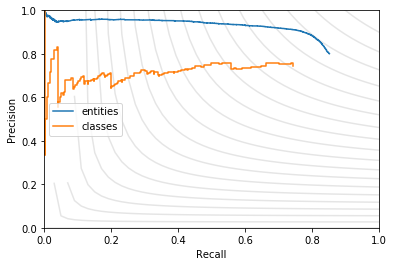

In [6]:
from takco.evaluate import pr_plot
pr_plot(report['curves'])

In [7]:
takco.preview( scored, nrows=None, hide_correct_rows=True )

# Further error analysis

In [ ]:
from takco.link import *

search = searcher_config.init_class(**globals())
print(search)
g = RDFSearcher(Trident(configuration='kb/dbpedia_t2ksubset/db/'))

missing_gold = []
mistake_gold = []
for table in scored:
    if table.get("gold", {}).get("entities"):
        for ci, ri_ents in table.get("gold", {}).get("entities").items():
            for ri, ents in ri_ents.items():
                for e in ents:
                    if e not in table.get("entities").get(ci, {}).get(ri, {}):
                        if not g.count([URIRef(e), None, None]):
                            missing_gold.append(e)
                        else:
                            row = [c.get('text') for c in table.get('tableData')[int(ri)]]
                            classes = list(table.get("gold", {}).get("classes", {}).get(ci, []))
                            cell = row[int(ci)]
                            context = [c for ci2,c in enumerate(row) if ci2 != int(ci)]
                            mistake_gold.append((e, cell, context, classes ))
                            
print('missing:', len(missing_gold), [mg.replace(search.baseuri, '') for mg in missing_gold[:50]])
print()


print('mistakes:', len(mistake_gold))
k = 3
import random
for e, cell, context, classes in random.sample(mistake_gold, 10):
    rs = list(search.search_entities(cell, context=context, classes=classes, limit=k, add_about=True))
    is_in_top_k = (e in [r.uri for r in rs])
    if is_in_top_k:
        continue
    print(e.split('/')[-1])
    print(' ', f'"{cell}", {context}, {classes}')
    print(' ', is_in_top_k, [r.uri.rsplit('/')[-1] for r in rs])
    print(' ', search.about(e))
    print()

In [ ]:
import logging
# logging.getLogger().setLevel(logging.DEBUG)

# cell, context, classes = "Bridge to Terabithia", ['Katherine Paterson', 'ALA [20]'], ['Book']
# cell, context, classes = "Italy", ['ITA', 'IT', 'Italian Lira', 'ITL'], ['http://dbpedia.org/ontology/Country']
# cell, context, classes = "Germany", ['DEU', 'DE', 'Deutsche Mark', 'DEM'], ['http://dbpedia.org/ontology/Country']
cell, context, classes = "Uganda", [], ['http://dbpedia.org/ontology/Country']

results = search.search_entities(cell, context, classes=classes, limit=3, add_about=True)

import pprint
for i, sr in enumerate(results):
    types = sr.get(RDF.type) or []
    print(i, sr.uri, sr.score, types)
    pprint.pprint(dict(sr))
    print()
    
logging.getLogger().setLevel(logging.WARN)